### Training an RNN to predict performance of executive RNN

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
rng = np.random.default_rng()
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})


In [2]:
import gym
import neurogym as ngym
tasks = ngym.get_collection('yang19')

In [3]:
tasks

['yang19.go-v0',
 'yang19.rtgo-v0',
 'yang19.dlygo-v0',
 'yang19.anti-v0',
 'yang19.rtanti-v0',
 'yang19.dlyanti-v0',
 'yang19.dm1-v0',
 'yang19.dm2-v0',
 'yang19.ctxdm1-v0',
 'yang19.ctxdm2-v0',
 'yang19.multidm-v0',
 'yang19.dlydm1-v0',
 'yang19.dlydm2-v0',
 'yang19.ctxdlydm1-v0',
 'yang19.ctxdlydm2-v0',
 'yang19.multidlydm-v0',
 'yang19.dms-v0',
 'yang19.dnms-v0',
 'yang19.dmc-v0',
 'yang19.dnmc-v0']

In [13]:
# load data
import os
print('cwd: ', os.getcwd())
exp_name = 'correlated_gates'
config_file = './../files/'+exp_name+ '/config_0_-0.3_2000.0_gaus_cut_tc_mul_gates.npy'
file1 = './../files/'+exp_name+ '/testing_log_0_-0.3_2000.0_gaus_cut_tc_mul_gates.npy'
training_file1 = './../files/'+exp_name+ '/training_log_0_-0.3_2000.0_gaus_cut_tc_mul_gates.npy'

config = np.load(config_file, allow_pickle=True).item()
testing_log = log = np.load( file1, allow_pickle=True).item()
training_log = np.load(training_file1, allow_pickle=True).item()


cwd:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis


In [15]:
# load data
import os
print('cwd: ', os.getcwd())
exp_name = 'order_order_order'
config_file = './../files/'+exp_name+ '/config_0_-0.3_100.0_gaus_cut_tc_mul_gates.npy'
file1 = './../files/'+exp_name+ '/testing_log_0_-0.3_100.0_gaus_cut_tc_mul_gates.npy'
training_file1 = './../files/'+exp_name+ '/training_log_0_-0.3_100.0_gaus_cut_tc_mul_gates.npy'

config = np.load(config_file, allow_pickle=True).item()
testing_log = log = np.load( file1, allow_pickle=True).item()
training_log = np.load(training_file1, allow_pickle=True).item()


cwd:  /home/ahummos/code/PFC_MD_Modeling/CL_neurogym/analysis


A sample of neural activities, from only 10 neurons

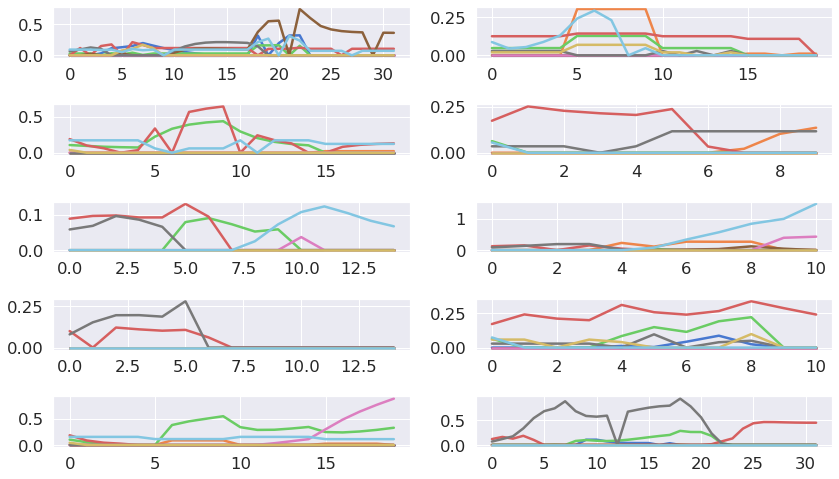

In [14]:
fig, axes = plt.subplots(5, 2, figsize = [12, 7] )

for i in range(10):
    idx = rng.integers(0, len(training_log.sampled_act))
    _=axes.flatten()[i].plot(training_log.sampled_act[idx][:,0,:])
fig.tight_layout()


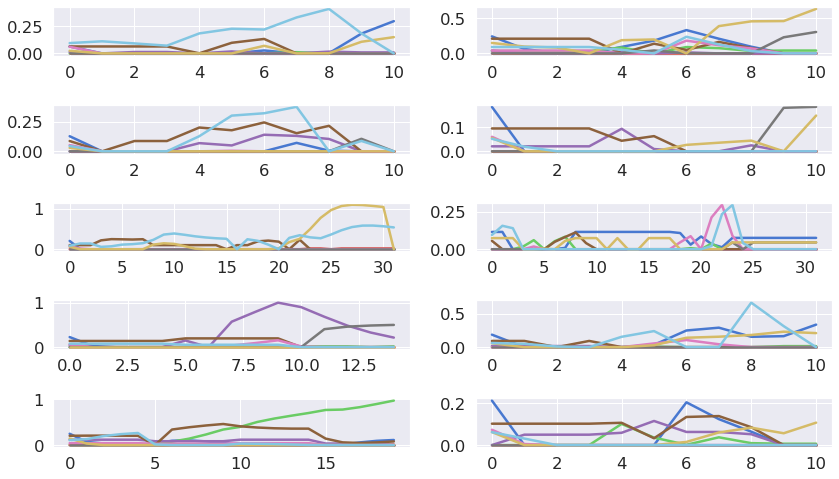

In [16]:
fig, axes = plt.subplots(5, 2, figsize = [12, 7] )

for i in range(10):
    idx = rng.integers(0, len(training_log.sampled_act))
    _=axes.flatten()[i].plot(training_log.sampled_act[idx][:,0,:])
fig.tight_layout()


AttributeError: 'SerialLogger' object has no attribute 'sampled_act'

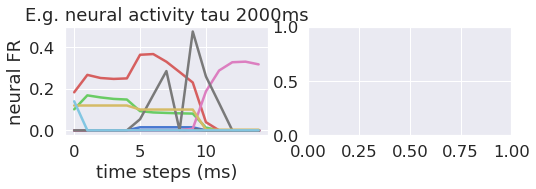

In [31]:
fig, ax =plt.subplots(1,2, figsize=[8,2])
# idx = rng.integers(0, len(training_log.sampled_act))
axes = ax[0]
_=axes.plot(training_log.sampled_act[idx][:,0,:])
axes.set_title('E.g. neural activity tau 2000ms')
axes.set_ylabel('neural FR')
axes.set_xlabel('time steps (ms)')
# plt.savefig('neural_activity_tau2000.jpg', dpi=300)


axes = ax[1]
training_filetau100 = './../files/'+'TAU2_gaussian_cut'+ '/training_log_0_-0.3_100.0_gaus_cut_tc_mul_nog.npy'
training_log_tau100 = np.load(training_filetau100, allow_pickle=True).item()

_=axes.plot(training_log_tau100.sampled_act[idx][:,0,:])
axes.set_title('E.g. neural activity tau 100ms')
axes.set_ylabel('neural FR')
axes.set_xlabel('time steps (ms)')
plt.savefig('neural_activity_tau100_2000.jpg', dpi=300)



In [11]:
inputs = (training_log.inputs)
acts = np.stack(training_log.rnn_activity)  # (3127, 100, 356)
outputs = np.stack(training_log.outputs)
labels = np.stack(training_log.labels)
accuracies = np.stack(training_log.accuracies)
task_ids = np.stack(training_log.task_ids)
gradients = np.stack(training_log.gradients)

rl = np.argmax(labels, axis=-1)
ro = np.argmax(outputs, axis=-1)
mses= ((labels-outputs)**2).mean(-1) # shape (7800, 100)
acc = (rl==ro).astype(np.float32)
# print('gradients shape: ', gradients.shape)
print('activations ape: ', acts.shape)
print('outputs  shape : ', outputs.shape)
print('labels   shape : ', labels.shape)
print('task_ids shape : ', task_ids.shape)
print('inputs 0 shape : ', inputs[0].shape)
print('inputs 1 shape : ', inputs[1111].shape)
print('acc shape: ', acc.shape)


activations ape:  (6997, 100, 356)
outputs  shape :  (6997, 100, 17)
labels   shape :  (6997, 100, 17)
task_ids shape :  (6997,)
inputs 0 shape :  (15, 100, 33)
inputs 1 shape :  (32, 100, 33)
acc shape:  (6997, 100)


acc shape:  (2887, 100)


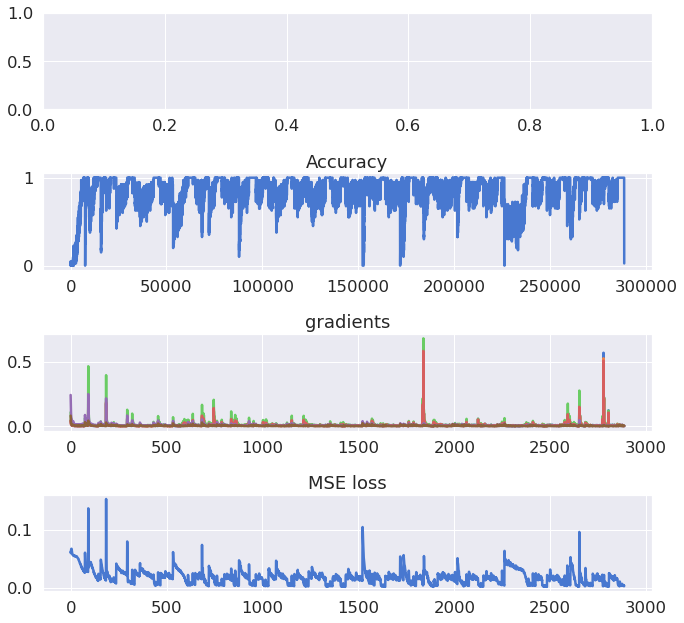

In [8]:

fig, axes = plt.subplots(4,1, figsize=[10,9])
# axes[0].scatter(range(61000), acc.reshape([-1])[:61000]) #.mean(1))
# axes[0].plot(np.convolve( np.ones(40)/40, acc.reshape([-1])[:61000])) #.mean(1))
axes[1].plot(np.convolve( np.ones(40)/40, acc.reshape([-1]))) #.mean(1))
axes[1].set_title('Accuracy')
axes[2].plot(gradients[:])
axes[2].set_title('gradients')
axes[3].plot(mses.mean(1))
axes[3].set_title('MSE loss')
plt.tight_layout()

In [12]:
previous_mse = np.concatenate([mses[:1], mses ])[:-1] #shift by one place to make it run one step behind. 
previous_acc = np.concatenate([acc[:1], acc ])[:-1] #shift by one place to make it run one step behind. 
print('previous acc shape: ', previous_acc.shape)

expanded_previous_acc = np.repeat(previous_acc[..., np.newaxis], 10, axis=-1)   #Expanded merely to emphasize their signal over the numerous acts
print('previous Expanded acc shape: ', expanded_previous_acc.shape)
gathered_inputs = np.concatenate([acts, labels, expanded_previous_acc], axis=-1) #shape  7100 100 266
print('Gathered inputs shape: ', gathered_inputs.shape)

task_ids_oh= F.one_hot(torch.from_numpy(task_ids), 15)
print('task_ids one hot encoded shape: ', task_ids_oh.shape)




previous acc shape:  (6997, 100)
previous Expanded acc shape:  (6997, 100, 10)
Gathered inputs shape:  (6997, 100, 383)
task_ids one hot encoded shape:  torch.Size([6997, 15])


In [13]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        # inp = self.bn(inp)
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

In [14]:
task_ids_repeated = task_ids[..., np.newaxis].repeat(100,1)
print('dims after adding batch dim: ', task_ids_repeated.shape)

dims after adding batch dim:  (6997, 100)


In [15]:
#hold out set
# training = list(range(2300)) + list(range(2500, 2887))
# testing = list(range(2300, 2500))
training = list(range(6000)) + list(range(6700, 6997))
testing = list(range(6000, 6700))

0.037: 100%|██████████| 2000/2000 [08:00<00:00,  4.17it/s]


Text(0.5, 0, 'Training batch')

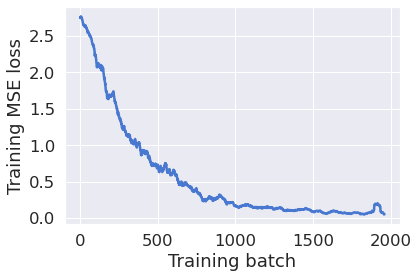

In [16]:
input_length = 20
training_cycles = 2000

rng = np.random.default_rng()

use_inputs = gathered_inputs[training]
# use_outputs= task_ids_oh.reshape([task_ids_oh.shape[0], 1, task_ids_oh.shape[1]]).repeat([1,use_inputs.shape[1], 1])
use_outputs= task_ids_repeated[training]

model = Net(input_size=use_inputs.shape[-1], hidden_size=258, output_size=task_ids_oh.shape[-1])
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
# crit = nn.CrossEntropyLoss(reduction='mean')
crit = F.cross_entropy

losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = rng.integers(0, use_inputs.shape[0]- input_length)
    # bi=1000 # NOTE One batch only TODO
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(use_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(use_outputs[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(input= pred.squeeze().permute([0,2,1]) , target = outs)
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)
ax = plt.gca()
ax.set_ylabel('Training MSE loss')
ax.set_xlabel('Training batch')


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


gru_acts shape :  (1, 60, 100, 258)
gru_preds shape :  (1, 60, 100, 15)
[11 11 11  3  3  3  3  3  3  3  3  3  3  8  8  8  8  8  8  8  8  8  8  8
 13 13 13 13 13 13 13 13 13 13 13 13 13 12 12 12 12 12 12 12 12 12 12 12
 12  6  6  6  6  6  6  6  6  6  6  6]


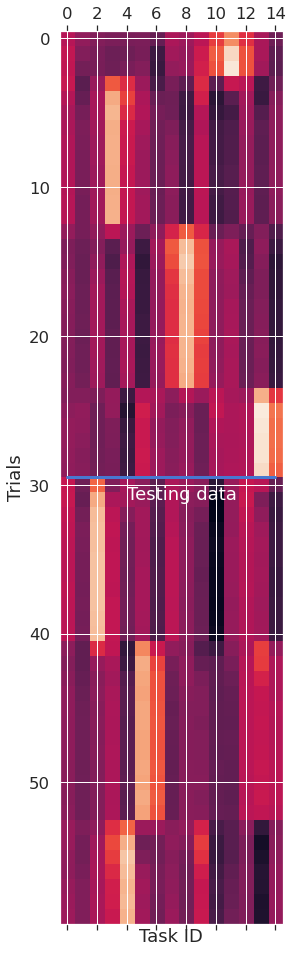

In [29]:
#eval
test_input_length= 60
model.eval()
gru_acts= []
gru_preds= []
b_example = 5970#2270
with torch.no_grad():
    # for b in trange (use_inputs.shape[0]//test_input_length):
    for b in trange (b_example, b_example+1):
        eins= torch.tensor(use_inputs[b:b+test_input_length])
        gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
    #     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        gru_acts.append(gacts.detach().cpu().numpy())
        gru_preds.append(gpreds.detach().cpu().numpy())
model.train()

gru_preds = np.stack(gru_preds)
gru_acts = np.stack(gru_acts)
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
plt.matshow(gru_preds.reshape([-1, 100, 15]).mean(1))
ax = plt.gca()
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')

print(task_ids[b_example:b_example+test_input_length])
plt.savefig('Cognitive_observer_preds.jpg', dpi=300)

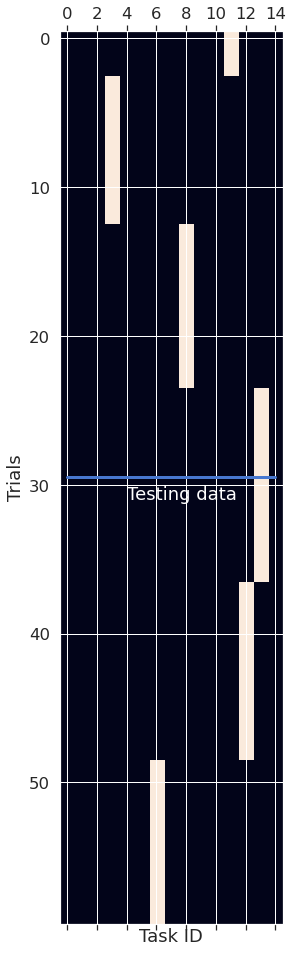

In [30]:
plt.matshow(task_ids_oh[b_example:b_example+test_input_length])
ax = plt.gca()
ax.plot(range(15), [29.5]*15, linewidth=(3))
ax.text(4, 31, 'Testing data', {'color': 'white'})
ax.set_ylabel('Trials')
ax.set_xlabel('Task ID')

plt.savefig('Cognitive_observer_gt.jpg', dpi=300)

shape of contactanted gru preds:  (2880, 15)


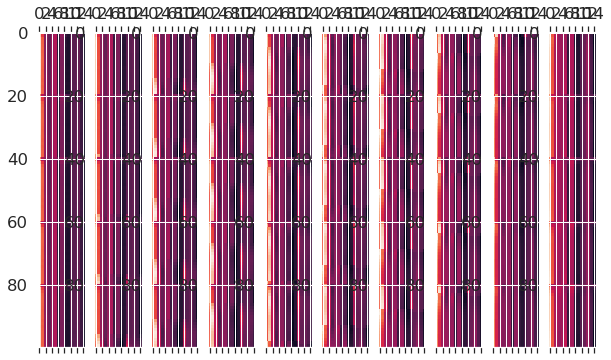

In [28]:
fig, axes = plt.subplots(1,10, figsize=[10,10])
gc = np.concatenate(gru_preds, axis =0).mean(1)
print('shape of contactanted gru preds: ', gc.shape)
for i in range(10):
    axes[i].matshow(gc[1000+(i*100):1000+(i*100)+100])

In [15]:
(task_ids[1000:1000+input_length])

array([4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6])

shae:  (2880, 15)


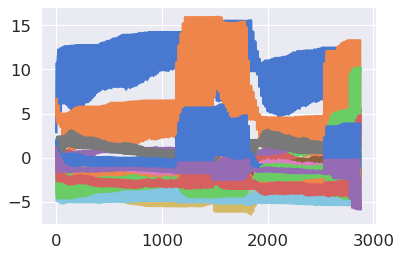

In [ ]:
print('shae: ', (gru_preds.reshape([-1, 100, 15]).mean(1)).shape)
plt.plot(gru_preds.reshape([-1, 100, 15]).mean(1))

In [ ]:
if False: # this is compabilbe only of labels anouptputs are not np.stacked
    fig, axes = plt.subplots(1,3, figsize=[6,6])
    trial_no = 5 #
    batch_no = 81 # in batch 601: 10 13 18 are false in all of them, it is too much noise!
    task_no = 9
    axes[0].matshow(inputs [task_no][batch_no][:,trial_no,:].T)
    axes[1].matshow(labels [task_no][batch_no][trial_no,:, np.newaxis])
    axes[2].matshow(outputs[task_no][batch_no][trial_no,:, np.newaxis])
    correct = np.argmax(outputs[task_no][batch_no][trial_no,:], axis =-1) == np.argmax(labels[task_no][batch_no][trial_no,:], axis =-1)
    print ('correct: ', correct)

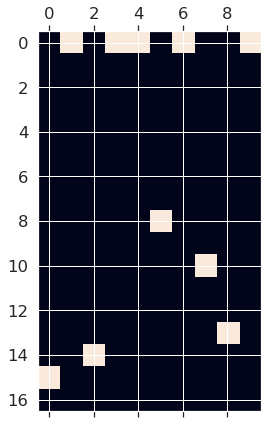

In [ ]:
plt.matshow(labels[700, :10,: ].T)

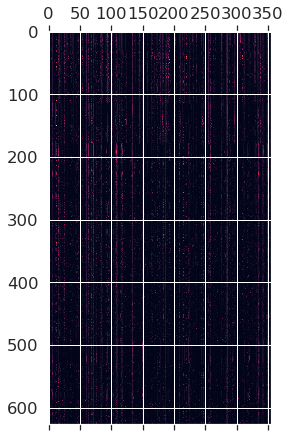

In [ ]:
plt.matshow(acts.reshape([-1, 356])[0:-1:500])

In [ ]:
print(change_trials)

In [ ]:
# create the task class vector
N = acts.reshape([-1, 256]).shape[0]
ct = [0]+change_trials
ct = [int(c*100) for c in ct]
task_class = np.zeros((N,1))
for i in range(num_tasks):
    task_class[ct[i]:ct[i+1]] = i
plt.plot(task_class)    

In [ ]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

In [ ]:
x= X_emb 

colors = task_class[0:-1:sampling_rate]
num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


acc shape:  (3127, 100)
previous reward shape:  (3127, 100)


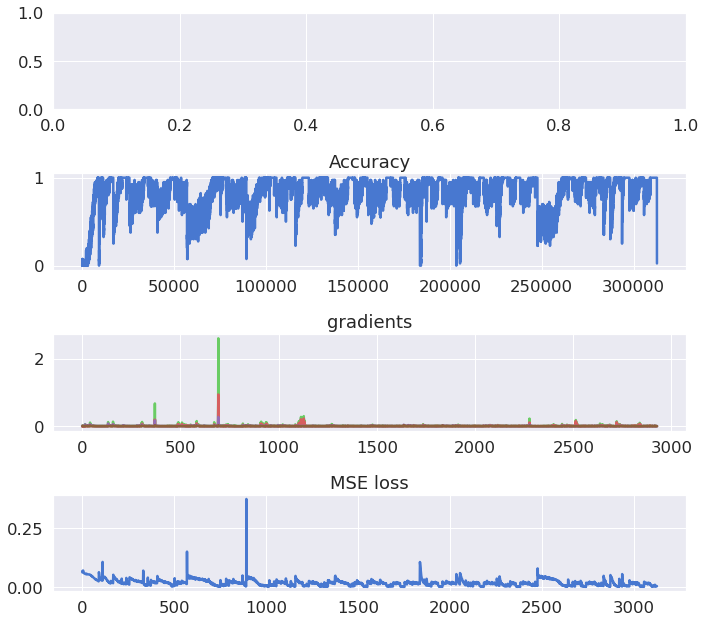

In [ ]:
rl = np.argmax(labels, axis=-1)
ro = np.argmax(outputs, axis=-1)
mses= ((labels-outputs)**2).mean(-1) # shape (7800, 100)

acc = (rl==ro).astype(np.float32)
print('acc shape: ', acc.shape)
fig, axes = plt.subplots(4,1, figsize=[10,9])
# axes[0].scatter(range(61000), acc.reshape([-1])[:61000]) #.mean(1))
# axes[0].plot(np.convolve( np.ones(40)/40, acc.reshape([-1])[:61000])) #.mean(1))
axes[1].plot(np.convolve( np.ones(40)/40, acc.reshape([-1]))) #.mean(1))
axes[1].set_title('Accuracy')
axes[2].plot(gradients[200:])
axes[2].set_title('gradients')
axes[3].plot(mses.mean(1))
axes[3].set_title('MSE loss')
previous_acc = np.concatenate([mses[:1], mses ])[:-1] #shift by one place to make it run one step behind. 
print('previous reward shape: ', previous_reward.shape)
plt.tight_layout()


### Start preparing for trainingz

In [ ]:
print('output shapes: ', acc.shape)
print('input shape: ' , acts.shape)

In [ ]:
expanded_previous_reward = np.repeat(previous_reward[..., np.newaxis], 10, axis=-1)
inpu = np.concatenate([acts, expanded_previous_reward], axis=-1) #shape  7100 100 266
input_length = 500
training_cycles = 200


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=False)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        # inp = self.bn(inp)
        out, hidden = self.gru(inp)
        x = self.linear(out)
        return x, out

In [ ]:
rng = np.random.default_rng()

use_inputs = expanded_previous_reward
model = Net(input_size=use_inputs.shape[-1], hidden_size=258, output_size=1)
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss(reduction='mean')
losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = np.random.randint(0, acts.shape[0]- input_length)
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(use_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(acc[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(outs, pred.squeeze() )
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)


In [ ]:
# Shapes cell:
print('shape of expanded_previous_rewaqrd: ', expanded_previous_reward.shape)


In [ ]:
rng = np.random.default_rng()

use_inputs = expanded_previous_acc
model = Net(input_size=use_inputs.shape[-1], hidden_size=258, output_size=1)
# model = nn.GRU(256, 1, batch_first=False)

optm = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss(reduction='mean')
losses = []
tbar = trange(training_cycles)
for train_i in tbar:
    
    # select a change point
    # t = rng.choice(np.array(change_trials[:-1]))
    # interval = rng.choice((np.arange(-int(input_length*4), 1)))
    # selected_trials = range(t+interval, t+interval + input_length) # sample from around the change point
    
    #Random batches
    bi = np.random.randint(0, acts.shape[0]- input_length)
    selected_trials = range(bi, bi+input_length)

    ins =  torch.tensor(use_inputs[selected_trials]) # (input_length, 100, 266)
    outs = torch.tensor(acc[selected_trials]) # (input_length, 100)

    pred, gru_act = model(ins) # Pred torch.Size([input_length, 100, 1])  gru_act: torch.Size([1, 100, 1])
    loss = crit(outs, pred.squeeze() )
    
    loss.backward()
    optm.step()
    optm.zero_grad()
    tbar.set_description('{:2.3f}'.format((loss.item())))
    losses.append(loss.item())


sloss = np.stack(losses)
sloss = np.convolve(np.ones(40)/40, sloss, 'valid')
plt.plot(sloss)



Now gather all acts[-1, 256] and somehow run them through the GRU but in eval mode. Get all the GRU activations, sample them at the same rate and with the same code and do the tsne.

### testing getting complicated

In [ ]:
#eval
model.eval()
gru_acts= []
gru_preds= []
with torch.no_grad():
    for b in trange (use_inputs.shape[0]//input_length):
        eins= torch.tensor(use_inputs[b:b+input_length])
        gpreds, gacts = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
    #     gacts, gpreds = model(eins) # torch.Size([50, 100, 1])  gacts:  torch.Size([50, 100, 256])
        gru_acts.append(gacts.detach().cpu().numpy())
        gru_preds.append(gpreds.detach().cpu().numpy())
model.train()

gru_preds = np.stack(gru_preds)
gru_acts = np.stack(gru_acts)
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
plt.plot(gru_preds.reshape([-1, 100, 1]).mean(1))

In [ ]:
print('gru_acts shape : ', gru_acts.shape)
print('gru_preds shape : ', gru_preds.shape)
plt.plot(gru_preds.reshape([-1, 100, 1]).mean(1))

In [ ]:
from tsne_torch import TorchTSNE as TSNE

sampling_rate = 200
X = gru_acts.reshape([-1, 256])[0:-1:sampling_rate]  # shape (n_samples, d)
colors = task_class[0:-1:sampling_rate]
X_emb = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=True).fit_transform(X)  # returns shape (n_samples, 2)

In [ ]:
x= X_emb 

num_classes = len(np.unique(colors))
palette = np.array(sns.color_palette("hls", num_classes))

# create a scatter plot.
f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])

# add the labels for each digit corresponding to the label
txts = []

for i in range(num_classes):

    # Position of each label at median of data points.

    xtext, ytext = np.median(x[colors.squeeze() == i, :], axis=0)
    txt = ax.text(xtext, ytext, config['human_task_names'][i], fontsize=24)
    txt.set_path_effects([
        PathEffects.Stroke(linewidth=5, foreground="w"),
        PathEffects.Normal()])
    txts.append(txt)


In [ ]:
def extract_accuracies(logs):
    train = []
    test = []
    num_tasks = len(logs)
    for logi in range(num_tasks):
        for task_i in range(num_tasks):
            log = logs[logi]
            if logi== task_i:
                train.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    #                 log['accuracy']task_i])
            else:
                test.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    return(np.stack(train), np.stack(test))


def extract_accuracies_all(logs):
    train = []

    num_tasks = len(logs)
    for logi in range(num_tasks):
        task_tests = []
        for task_i in range(num_tasks):
            log = logs[logi]
            task_tests.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
        train.append(task_tests)
    return(np.stack(train))


# def get_np_acc(logs, num_tasks):
#     logs_tasks_tests_acc = []
#     for logi in range(len(logs)):
#         test_accuracies = []
#         for task_i in range(num_tasks):
#             test_accuracies.append([t[task_i] for t in logs[logi]['accuracy']])
#         logs_tasks_tests_acc.append(np.stack(test_accuracies))

#     ltta = np.stack(logs_tasks_tests_acc)
#     return(ltta)


# tr_acc = get_np_acc(train, 15)
# te_acc = get_np_acc(test, 15)

In [ ]:
# two figs 
plt.close('all')
logs = testing_logs1
num_tasks = len(logs)
title_label = 'Training tasks sequentially ---> \n    ' #+ config['exp_name']
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs1[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, label=label1)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5, label=label1)
        if True:
            log = testing_logs2[logi]
            ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, color='tab:orange', label=label2)

        if li == 0: ax.set_title(config['human_task_names'][logi])
            
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[1, num_tasks-1].legend()

for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        log = testing_logs2[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)

        
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
      mul_gate: {"True" if config["use_gates"] else "False"}\
          {exp_signature}'
axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig(f'./files/{label1}_vs_{label2}.png', dpi=300)

In [ ]:
tr1, te1 = extract_accuracies(testing_logs1)
tr2, te2 = extract_accuracies(testing_logs2)


In [ ]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
ax = axes[0,0]
ax.set_title('trained task')
ax.plot(testing_logs1[0]['stamps'], tr1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], tr2.mean(axis=(0)), color='red', label=label2)
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('performance')
ax.set_xlabel('batch #')
ax.legend()

ax = axes[0,1]
ax.set_title('other tasks')
ax.plot(testing_logs1[0]['stamps'], te1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], te2.mean(axis=(0)), color= 'red', label=label2)
ax.set_xlabel('batch #')
ax.legend()

ax.set_ylim([-0.1, 1.1])
# fig.savefig('./files/gates_no_gates_comp.jpg')
fig.savefig(f'./files/{label1}_{label2}comp.png', dpi=600)

logs[0]['accuracy'] has 20 enteries for each time step, and each entry has accuracy of all tasks at that time step.

In [ ]:
tt = extract_accuracies_all(logs)

In [ ]:
def get_diffs(logs, triangle='upper', k=1):
    '''take a log, and return the improvement in the mean accuracy of tasks
    triangle: look at "upper" or "lower" triangle corrospondin to "after" or "before" index task was trained
    k: take from diagonal (0) or above it (1) or below it (-1)'''
    
    tt = extract_accuracies_all(logs)
    tavg = tt.mean(-1)

    tdiff = tavg[1:, :] -  tavg[:-1, :]    
    if triangle == 'upper':
        tri = tdiff[np.triu_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
    elif (triangle == 'lower'):
        tri = tdiff[np.tril_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri    
    
    sorted_diffs = np.sort(tri)
    return(sorted_diffs)


comp1 = get_diffs(testing_logs1, 'upper', 1)
comp2 = get_diffs(testing_logs2, 'upper', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('upper')


In [ ]:
comp1 = get_diffs(testing_logs1, 'lower', 1)
comp2 = get_diffs(testing_logs2, 'lower', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('lower')


In [ ]:
comp1.mean()

In [ ]:
comp2.mean()

In [ ]:
tavg = tt.mean(-1)

In [ ]:
tavg

In [ ]:
tdiff = tavg[1:, :] -  tavg[:-1, :]

In [ ]:
tdiff.shape

In [ ]:
np.triu(tdiff,1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
np.tril(tdiff,-1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

In [ ]:
ut = tdiff[np.triu_indices_from(tdiff,1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
lt = tdiff[np.tril_indices_from(tdiff,-1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri

In [ ]:
tdiff[np.tril_indices_from(tdiff,-1)]

In [ ]:
tdiff.shape

In [ ]:
plt.bar(range(ut.shape[0]), np.sort(ut))
plt.bar(range(lt.shape[0]), np.sort(lt))


In [ ]:
help(np.sort)

In [ ]:
te1.shape

In [ ]:
with_gates_te = te_acc
with_gates_tr = tr_acc

In [ ]:

fig, ax = plt.subplots(1)
logs = testing_logs

train = []
test = []
for logi in range(num_tasks):
    for li in range(num_tasks):
        log = testing_logs[logi]
        if logi== li:
            train.append(logs[logi]['accuracy'])
        else:
            test.append(logs[logi]['accuracy'])

    
            
train = np.stack(train)
test = np.stack(test)
print(train.shape)
print(test.shape)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0, max_x])
ax.plot(log['stamps'], train.mean(axis=0), linewidth=2)
ax.plot(log['stamps'], test.mean(axis=0), color='grey', linewidth=2)
# if li == 0: ax.set_title(config['human_task_names'][logi])
# if logi == 0: ax.set_ylabel(config['human_task_names'][li])
ax.set_yticklabels([]) 
ax.set_xticklabels([])
        
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
    ax.set_xlabel('batch #')


In [ ]:
np.stack(train[0][0].values())

In [ ]:
logs[0]['accuracy']

In [ ]:
test_accuracies = []
for task_i in range(15):
    test_accuracies.append([test[task_i] for test in logs[0]['accuracy']])


In [ ]:
ta = np.stack(test_accuracies)

In [ ]:

ta.shape

In [ ]:
ta

In [ ]:
task_i = 0
zz= zip(log['stamps'], [test[task_i] for test in logs[0]['accuracy']])

In [ ]:
[print( (z, a)) for z, a in zz]